In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
DIR_TRAIN = '../Data/Use/Train/'
os.listdir(DIR_TRAIN)
print('# Species in train set:',len(os.listdir(DIR_TRAIN)))

# Species in train set: 10


In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = train_datagen.flow_from_directory(DIR_TRAIN,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                shuffle=False)

Found 1000 images belonging to 10 classes.


In [5]:
X = np.concatenate([train_datagen.next()[0] for i in range(train_datagen.__len__())])

In [6]:
CASPIAN_TERN = X[0:100]
D_ARNAUDS_BARBET = X[100:200]
DARK_EYED_JUNCO = X[200:300]
HOUSE_FINCH = X[300:400]
OVENBIRD = X[400:500]
OYSTER_CATCHER = X[500:600]
RED_TAILED_HAWK = X[600:700]
SWINHOES_PHEASENT = X[700:800]
VIOLET_GREEN_SWALLOW = X[800:900]
WOOD_DUCK = X[900:1000]

#### K-Fold Autoencoder training (Spoiler: It doesn't work)

In [59]:
def k_fold_training(list_of_data):

    lis = []
    lis2 = []

    for x in list_of_data:
        # Save the n-1 images to the list
        for i in range(len(x)-1):
            lis.append(x[i+1])
            lis2.append(x[i])
    
    tup = (lis, lis2)

    return tup

tup = k_fold_training([WOOD_DUCK, CASPIAN_TERN, D_ARNAUDS_BARBET, DARK_EYED_JUNCO, HOUSE_FINCH, OVENBIRD, OYSTER_CATCHER, RED_TAILED_HAWK, SWINHOES_PHEASENT, VIOLET_GREEN_SWALLOW])

print(np.shape(tup))

(2, 990, 224, 224, 3)


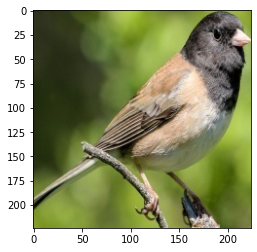

In [62]:
plt.imshow(tup[0][350])

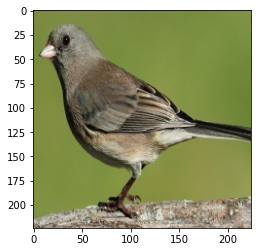

In [64]:
plt.imshow(tup[1][350])

In [65]:
dataset = tf.data.Dataset.from_tensor_slices(tup)

type(dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [66]:
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.map(lambda x, y: (tf.expand_dims(x, 0), tf.expand_dims(y, 0)))

dataset.element_spec

(TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name=None))

In [67]:
expe = dataset.shuffle(buffer_size=10)

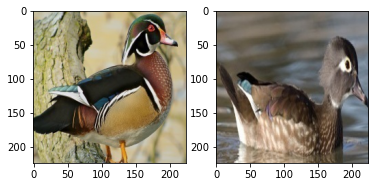

In [68]:
plt.subplot(1,2,1)
plt.imshow(tf.squeeze(expe.as_numpy_iterator().next()[0],[0]))
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(expe.as_numpy_iterator().next()[1],[0]))

In [69]:
# Prepare both datasets 

normal_dataset = dataset.prefetch(20)

dataset_with_shuffle = expe.prefetch(20)

_______________

In [7]:
class autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(autoencoder, self).__init__()
        
        self.encoder = [
            tf.keras.layers.InputLayer(input_shape=(None,224,224,3)),
            tf.keras.layers.Conv2D(filters=4,kernel_size=3,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2D(filters=8,kernel_size=3,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2D(filters=16,kernel_size=3,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim*latent_dim*3)
        ]

        self.decoder = [
            tf.keras.layers.Reshape(target_shape=(latent_dim,latent_dim,3)),
            tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=2,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=2,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=2,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=2, strides=2, padding='valid', activation='sigmoid'),
            tf.keras.layers.Reshape(target_shape=(224,224,3))
        ]

    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x

    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x

    @tf.function
    def call(self, input):
        x = self.encode(input)
        x = self.decode(x)
        return x

In [8]:
auto = autoencoder(latent_dim=14)

auto.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
auto.build(input_shape=(None,224,224,3))

In [ ]:
auto.fit(dataset, epochs=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

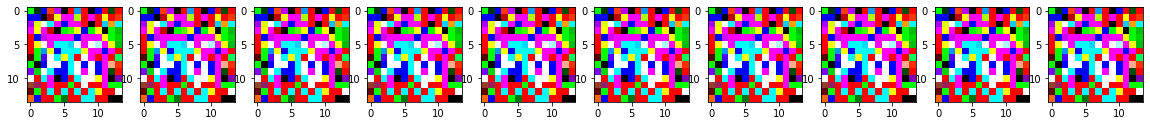

In [73]:
bird = DARK_EYED_JUNCO

plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    image_to_predict = tf.expand_dims(bird[i], 0).numpy()
    embeddings = auto.encode(image_to_predict).numpy()  
    plt.imshow(embeddings.reshape(14,14,3))

#### Normal Autoencode (Same Inputs as Targets) training

In [10]:
auto2 = autoencoder(latent_dim=14)

auto2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
auto2.build(input_shape=(None,224,224,3))

In [11]:
auto2.fit(X, X, epochs=50, batch_size=64)

Epoch 1/50
16/16 [==============================] - 6s 66ms/step - loss: 0.0575 - accuracy: 0.4877
Epoch 2/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0572 - accuracy: 0.5499
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0569 - accuracy: 0.5499
Epoch 4/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0567 - accuracy: 0.5498
Epoch 5/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0564 - accuracy: 0.5348
Epoch 6/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0562 - accuracy: 0.5226
Epoch 7/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0557 - accuracy: 0.5133
Epoch 8/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0542 - accuracy: 0.5200
Epoch 9/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0507 - accuracy: 0.5310
Epoch 10/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0438 - accuracy: 0.5179
Epoch 11/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


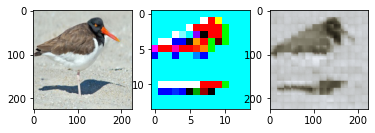

In [34]:
bird = OYSTER_CATCHER[25]

image_to_predict = tf.expand_dims(bird, 0).numpy()

plt.subplot(1,3,1)
plt.imshow(bird)
plt.subplot(1,3,2)
embedding = auto2.encode(image_to_predict)
plt.imshow(embedding.numpy().reshape(14,14,3))
plt.subplot(1,3,3)
pred = auto2.decode(embedding)
plt.imshow(pred.numpy().reshape(224,224,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

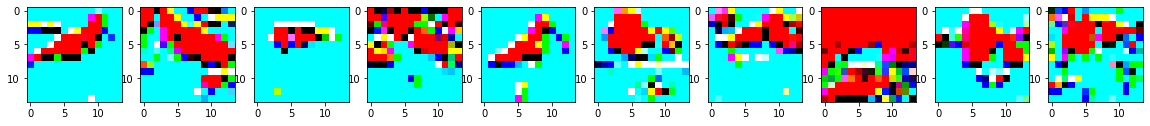

In [13]:
bird = OYSTER_CATCHER

plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    image_to_predict = tf.expand_dims(bird[i], 0).numpy()
    embeddings = auto2.encode(image_to_predict).numpy()  
    plt.imshow(embeddings.reshape(14,14,3))

#### Looking for similarities in the embeddings using T-SNE

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns

print('Dataset:',X.shape)

out = auto2.encode(X.astype(np.float32))

print('After embeddings',out.shape)

tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
results = tsne.fit_transform(out)

Y = np.concatenate([train_datagen.next()[1] for i in range(train_datagen.__len__())])

print(np.shape(results[:,0]))

plt.figure(figsize=(10,7))
sns.scatterplot( x=results[:,0], y=results[:,1],hue=Y,palette=sns.color_palette("hls", 10),data=results,legend="full", alpha=0.7)
plt.title('t-SNE embedding')
plt.show()

Dataset: (1000, 224, 224, 3)
After embeddings (1000, 588)
(1000,)


Exception: Data must be 1-dimensional

<Figure size 720x504 with 0 Axes>

##### Save the embeddings to the respective folder

In [35]:
DIR_TRAIN = '../Data/Use/Train/'

# store the bird names in a list
bird_names = [name for name in os.listdir(DIR_TRAIN)]

# dictionary for storing the images belonging to each bird class
bird_dic = {}

# for each bird class, get the list of jpgs
for name in bird_names:
  bird_dic[name] = [fn for fn in os.listdir('{}/{}'.format(DIR_TRAIN, name)) if fn.endswith('jpg')]

In [ ]:
from tensorflow.keras.preprocessing import image
from PIL import Image

DIR_DISTILLED = '../Data/Use/Preprocessed/Distilled/'

# prepare a folder for the augmented images

if os.path.exists('../Data/Use/Preprocessed/Distilled/..'):
    os.removedirs('../Data/Use/Preprocessed/Distilled')

os.mkdir('../Data/Use/Preprocessed')
os.mkdir('../Data/Use/Preprocessed/Distilled')


def save_img(dict):
    """
    Creates a folder and saves the distilled images of each class.
    
    Parameters:
    ----------
    dict : dictionary
        dictionary with the training images from each class
    """
    for key, value in dict.items():
        os.mkdir('../Data/Use/Preprocessed/Distilled/' + key)
        for img in value:

            fp = '{}/{}/{}'.format(DIR_TRAIN, key, img)
            fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')

            distilled_image = auto2.encode(tf.expand_dims(fn, 0).numpy())

            name = img.strip('.jpg')

            distilled_image.save(f'../Data/Use/Preprocessed/Distilled/{key}/{name}_augmented.jpg')


save_img(bird_dic)